In [1]:
import sys
sys.path.append('../')

import yaml
import numpy as np
import pandas as pd
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, SkyOffsetFrame, EarthLocation, AltAz

from matplotlib import pyplot

from srcsim.mc import MCCollection
from srcsim.src import generator as srcgen
from srcsim.run import DataRun

# Simulation

Global configuration defining what will be simulated

In [2]:
cfg = yaml.load(open('run_example.yaml', "r"), Loader=yaml.FullLoader)

### MC file

In [3]:
# file_name = 'dl2_gamma-diffuse_20deg_180deg_20201125_v0.6.3_prod5_v00_testing.h5'
# file_name = "dl2_gamma-diffuse_testing.h5"

# max_samples = 1000

# mc = MCCollection(file_name)
# mc.samples = mc.samples[:max_samples]
# mc

In [4]:
mc = {
    emission_type: MCCollection(cfg['mc'][emission_type]['files'])
    for emission_type in cfg['mc']
}

for emission_type in mc:
    if cfg['mc'][emission_type]['max_samples'] is not None:
        mc[emission_type].samples = mc[emission_type].samples[:cfg['mc'][emission_type]['max_samples']]

### Sources

In [5]:
srcs = srcgen(cfg['sources'])
srcs

GaussSource instance
    Name................: source
    Emission type.......: gamma
    Position............: <SkyCoord (ICRS): (ra, dec) in deg
    (83., 22.)>
    Sigma...............: 0.3 deg

DiskSource instance
    Name................: source
    Emission type.......: gamma
    Position............: <SkyCoord (ICRS): (ra, dec) in deg
    (83., 20.)>
    Radius..............: 0.3 deg

IsotropicSource instance
    Name................: source
    Emission type.......: proton
    Position............: <SkyCoord (ICRS): (ra, dec) in deg
    (83., 20.)>



### Data "run"

Can define a run by hand...

In [6]:
# #Can define a run by hand...
# lst_loc = EarthLocation(lat=28.761758*u.deg, lon=-17.890659*u.deg, height=2200*u.m)
# run = DataRun(
#     SkyCoord(83, 21, unit='deg', frame='icrs'),
#     Time('2022-05-31T15:00:00'),
#     Time('2022-05-31T15:20:00'),
#     lst_loc
# )

... but better take the settings from the specified configuration.

In [7]:
run = DataRun.from_config(cfg['run'])
run

DataRun instance
    Tel. RA/Dec.........: <SkyCoord (ICRS): (ra, dec) in deg
    (83., 21.)>
    Tstart..............: 2022-05-31T15:00:00.000
    Tstop...............: 2022-05-31T15:20:00.000
    Tel. azimuth........: [239.30 deg - 248.48 deg]
    Tel. alt............: [76.00 deg - 72.05 deg]



### Simulation...

In [8]:
evt = [
    run.predict(
        mc,
        src,
        tel_pos_tolerance=180*u.deg,
        time_step=1*u.minute
    )
    for src in srcs
]
events = pd.concat(evt)

In [9]:
evtdl3 = events.query('mc_energy > 0.1 & intensity > 100 & gammaness > 0.5')

# Ploting the simulated events

In [10]:
lst_focal_length = 28.01 * u.m
cam2angle = 1 * u.rad / lst_focal_length
cam_x, cam_y = evtdl3[['src_x', 'src_y']].to_numpy().transpose() * u.m * cam2angle

In [11]:
tel_pos = run.tel_pos
frame = AltAz(
    obstime=Time(evtdl3['dragon_time'], format='unix'),
    location=run.obsloc
)

tel_pos = run.tel_pos.transform_to(frame)

offset_frame = SkyOffsetFrame(
    origin=tel_pos.altaz.skyoffset_frame().origin,
    location=tel_pos.altaz.frame.location,
    obstime=tel_pos.altaz.frame.obstime
)

coords = SkyCoord(
    evtdl3['src_x'].to_numpy() * u.m * cam2angle,
    evtdl3['src_y'].to_numpy() * u.m * cam2angle,
    frame=offset_frame
)

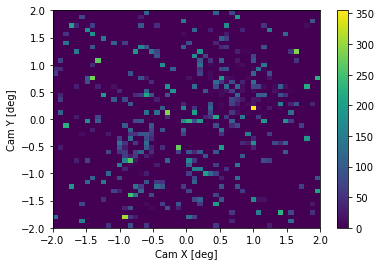

In [12]:
pyplot.xlabel('Cam X [deg]')
pyplot.ylabel('Cam Y [deg]')
pyplot.hist2d(
    cam_x.to('deg').value,
    cam_y.to('deg').value,
    range=(
        (-2, 2),
        (-2, 2)
    ),
    bins=50
);
pyplot.colorbar()

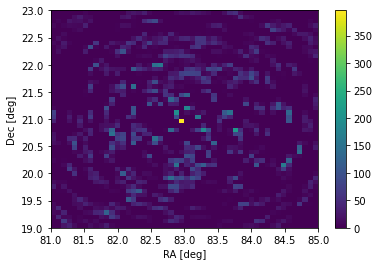

In [13]:
pyplot.xlabel('RA [deg]')
pyplot.ylabel('Dec [deg]')
pyplot.hist2d(
    coords.icrs.ra.to('deg').value,
    coords.icrs.dec.to('deg').value,
    range=[
        (run.tel_pos.ra.to('deg').value - 2, run.tel_pos.ra.to('deg').value + 2),
        (run.tel_pos.dec.to('deg').value - 2, run.tel_pos.dec.to('deg').value + 2)
    ],
    bins=50
);
pyplot.colorbar()

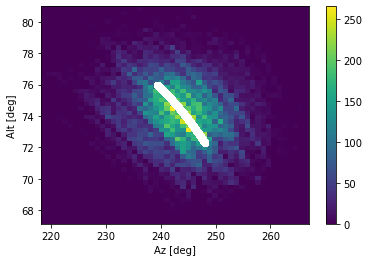

In [14]:
pyplot.xlabel('Az [deg]')
pyplot.ylabel('Alt [deg]')

pyplot.hist2d(
    (evtdl3['reco_az'].to_numpy() * u.rad).to('deg').value,
    (evtdl3['reco_alt'].to_numpy() * u.rad).to('deg').value,
    bins=50
);
pyplot.colorbar()

pyplot.scatter(
    tel_pos.az.to('deg').value,
    tel_pos.alt.to('deg').value,
    color='white'
)

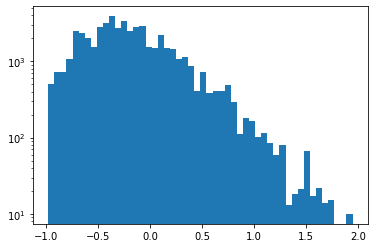

In [15]:
pyplot.semilogy()
pyplot.hist(
    np.log10(evtdl3['mc_energy']),
    # np.log10(mcevents.samples[0].data_table['mc_energy']),
    bins=50
);

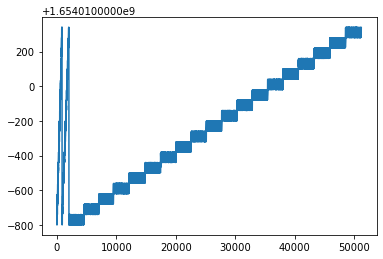

In [16]:
pyplot.plot(
    evtdl3['dragon_time'].to_numpy(),
)